# NLP Project: Hate Speech Detection

## Task 0: Initializing stuff

First, we import and initialize slow-loading libraries used in the rest of the notebook, so we don't have to do that every time we make a change to a cell later on.

We also download our data here.

In [1]:
import utils
import matplotlib.pyplot as plt 
import nltk
import pandas as pd

import pysentiment2 as ps
# Initialize Harvard IV-4 dictionary
hiv4 = ps.HIV4()

# Initialize nltk
nltk.download('punkt')
nltk.download('stopwords')

# Download data if needed
conan_fname = utils.download('https://raw.githubusercontent.com/marcoguerini/CONAN/master/CONAN.json')

conan_json = utils.read_json(conan_fname)
hate_texts, counter_texts = utils.parse_conan(conan_json)

/home/kurre/projects/hatespeech/env/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


/home/kurre/projects/hatespeech/CONAN.json exists, skipping download


[nltk_data] Downloading package punkt to /home/kurre/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/kurre/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Task 1 - Word Cloud

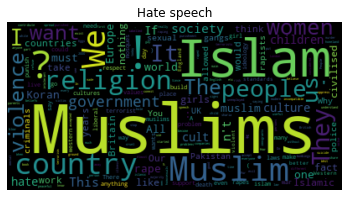

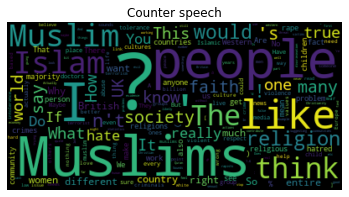

In [2]:
from wordcloud import WordCloud

hate_wc = utils.count_words(hate_texts)
counter_wc = utils.count_words(counter_texts)

for wc, title in [(hate_wc, 'Hate speech'), (counter_wc, 'Counter speech')]:
    wordcloud = WordCloud().generate_from_frequencies(wc)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

## Task 2: Empath analysis

In [3]:
from empath import Empath
lexicon = Empath()

def analyse_texts(texts):
    return {key: value for key, value in lexicon.analyze(texts).items() if value > 0.0}

hate_analysis = analyse_texts(hate_texts)
counter_analysis = analyse_texts(counter_texts)

def pretty_print(analysis, n=10):
    sorted_analysis = [(k, v) for k, v in sorted(analysis.items(), key=lambda i: i[1], reverse=True)]
    for k, v in sorted_analysis[:n]:
        print(f'{k:<18}: {v:>4.0f}')

print('Hate speech'.center(24, '='))
pretty_print(hate_analysis)
print()
print('Counter speech'.center(24, '='))
pretty_print(counter_analysis)

======Hate speech=======
crime             :  729
violence          :  658
religion          :  637
negative_emotion  :  600
law               :  553
aggression        :  536
hate              :  504
worship           :  450
sexual            :  436
government        :  429

=====Counter speech=====
speaking          :  774
negative_emotion  :  723
divine            :  606
positive_emotion  :  579
religion          :  567
communication     :  540
crime             :  501
violence          :  501
trust             :  459
philosophy        :  435


## Task 3: Sentiment analysis

In [4]:
def score_texts(texts):
    return [hiv4.get_score(hiv4.tokenize(text)) for text in texts]

hate_scores = score_texts(hate_texts[:10])
counter_scores = score_texts(counter_texts[:10])

hate_score = pd.DataFrame.from_records(hate_scores).mean().to_dict()
counter_score = pd.DataFrame.from_records(counter_scores).mean().to_dict()

print('Hate speech', hate_score)
print('Counter speech', counter_score)

Hate speech {'Positive': 1.3, 'Negative': 1.1, 'Polarity': 0.2666663777780741, 'Subjectivity': 0.21623374560212727}
Counter speech {'Positive': 2.7, 'Negative': 3.4, 'Polarity': -0.21439555173174768, 'Subjectivity': 0.40034109979783344}


## Task 4: Create heuristic to detect hate speech

In [5]:
import json
import pickle

import tensorflow as tf

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

import utils

### Preprocess the data
Calculate the categories and sentiment analysis for every tweet. Then label it 

In [6]:
DIVIDER_FOR_DATASET = 2
data_split = int(len(hate_texts)/DIVIDER_FOR_DATASET) # Get the "halfway-point" of the dataset

# First section of the data is to train the model
train_items, train_labels = utils.get_nn_input(hate_texts[:data_split], counter_texts[:data_split])

# Second section of the data is to evaluate the model
evaluate_items, evaluate_labels = utils.get_nn_input(hate_texts[data_split:], counter_texts[data_split:])

  1% (25 of 1932) |                      | Elapsed Time: 0:00:00 ETA:   0:00:10

Parsing the hate and counter tweets into inputs for the neural network.


100% (1932 of 1932) |####################| Elapsed Time: 0:00:10 Time:  0:00:10
100% (1932 of 1932) |####################| Elapsed Time: 0:00:11 Time:  0:00:11
  0% (14 of 1932) |                      | Elapsed Time: 0:00:00 ETA:   0:00:13

Parsing the hate and counter tweets into inputs for the neural network.


100% (1932 of 1932) |####################| Elapsed Time: 0:00:12 Time:  0:00:12
100% (1932 of 1932) |####################| Elapsed Time: 0:00:12 Time:  0:00:12


First we teach the model with half of the CONAN dataset

In [7]:
def teach(train_items, train_labels):

    model = tf.keras.Sequential([
        # each train_items item has 198 fields, so that is the number of neurons we need in the first layer of network
        tf.keras.layers.Input(198,),
        tf.keras.layers.Dense(50, activation='relu'),
        tf.keras.layers.Dense(35),
        tf.keras.layers.Dense(2, activation='sigmoid')
    ])

    # Optimizer uses adaptive learning rates (adam optimizer)
    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

    print("Teaching the model")
    model.fit(train_items, train_labels, epochs=10)
    model.summary()
    return model

nn_model = teach(train_items, train_labels)

Teaching the model
Epoch 1/10
121/121 [==============================] - 0s 490us/step - loss: 0.6645 - accuracy: 0.5919
Epoch 2/10
121/121 [==============================] - 0s 486us/step - loss: 0.6396 - accuracy: 0.6234
Epoch 3/10
121/121 [==============================] - 0s 469us/step - loss: 0.6079 - accuracy: 0.6913
Epoch 4/10
121/121 [==============================] - 0s 463us/step - loss: 0.5697 - accuracy: 0.7391
Epoch 5/10
121/121 [==============================] - 0s 453us/step - loss: 0.5391 - accuracy: 0.7692
Epoch 6/10
121/121 [==============================] - 0s 459us/step - loss: 0.5165 - accuracy: 0.8018
Epoch 7/10
121/121 [==============================] - 0s 453us/step - loss: 0.4962 - accuracy: 0.8178
Epoch 8/10
121/121 [==============================] - 0s 486us/step - loss: 0.4819 - accuracy: 0.8313
Epoch 9/10
121/121 [==============================] - 0s 468us/step - loss: 0.4714 - accuracy: 0.8427
Epoch 10/10
121/121 [==============================] - 0s 460us

## Task 5: Evaluate the heuristic from task 4

And then we evaluate the model with the second half of the dataset

In [8]:
def evaluate(model, evaluate_items, evaluate_labels):
    test_loss, test_acc = model.evaluate(evaluate_items, evaluate_labels, verbose=2)

    print("Accuracy of the heuristic against CONAN dataset: ", test_acc)
    
evaluate(nn_model, evaluate_items, evaluate_labels)

121/121 - 0s - loss: 0.6898 - accuracy: 0.5805
Accuracy of the heuristic against CONAN dataset:  0.580486536026001


## Task 6: https://github.com/pinkeshbadjatiya/twitter-hatespeech

Atte had problems setting this project up. 1) Python2 and its dependencies -> getting the project to run properly, 2) Scraping tweets from Twitter.

## Task 7: https://github.com/younggns/comparative-abusive-lang

Clone the project to the same directory as this project. Make a directory called "data" in there.

In [9]:
# Use the same data that we used to teach our own heuristic
# hate_texts, counter_texts
data = utils.preprocess_7(hate_texts, counter_texts)
print(data["0"])


['hate', 'According to a recent OFSTED report, a school in Birmingham is still segregating girls and boys, despite a Hight Court ruling in 2017 that this is unlawful.', '']


line 24 from data_preprocess.py needs to be changed to:

> return re.sub(str(pattern), repl, str(text), flags=FLAGS)

from

>return re.sub(pattern, repl, text, flags=FLAGS)

before running

> python3 data_preprocess.py


Go to ./model and run the training of the model:
> python3 train_ml_models.py --clf NB 

It will ask for inputs, to which we gave the values:
* 1,3
* 1200

### Output from teaching

             precision   recall  f1-score  support
hate           0.90223  0.94561   0.92333    386.4
counter        0.94304  0.89762   0.91969    386.4
avg / total    0.92272  0.92158   0.92154    772.8


| header | precision | recall | f1-score | support |
| --- | --- | --- | --- | --- |
| hate | 0.90223 | 0.94561 | 0.92333 | 386.4 |
counter        0.94304  0.89762   0.91969    386.4
avg / total    0.92272  0.92158   0.92154    772.8
